In [37]:
import obspy 
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm import tqdm
import os
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score

import time

In [59]:
stns = pd.read_csv('gmap-stations.txt', sep='|', skiprows=[2,6])
stns

,#Network,Station,Latitude,Longitude,Elevation,Sitename,StartTime,EndTime
0,AK,BAE,61.131900,-148.123400,578.0,"Barry Arm East, AK, USA",2020-09-04T00:00:00,2599-12-31T23:59:59
1,AK,BAT,61.141600,-148.175100,1027.0,"Barry Arm Top, AK, USA",2021-07-23T00:00:00,2599-12-31T23:59:59
2,AK,BAW,61.150100,-148.150100,542.0,"Barry Arm West, AK, USA",2020-09-04T00:00:00,2021-04-30T23:59:59
3,AK,EYAK,60.548698,-145.750000,133.9,"Cordova Ski Area, AK, USA",2002-10-03T00:00:00,2599-12-31T23:59:59
4,AK,FID,60.727699,-146.598694,500.0,"Fidalgo, AK, USA",2010-07-26T00:00:00,2599-12-31T23:59:59
5,AK,GLI,60.879200,-147.095901,430.0,"Glacier Island, AK, USA",2010-07-26T00:00:00,2599-12-31T23:59:59
6,AK,HIN,60.396000,-146.503494,622.9,"Hinchinbrook, AK, USA",2009-11-01T00:00:00,2599-12-31T23:59:59
7,AK,KLU,61.492400,-145.922700,1047.1,"Klutina Pass, AK, USA",2008-09-13T00:00:00,2599-12-31T23:59:59
8,AK,KNK,61.413100,-148.458500,598.0,"Knik Glacier, AK, USA",2010-06-13T00:00:00,2599-12-31T23:59:59
9,AK,M23K,61.792900,-147.726200,583.0,"Glacier View, AK, USA",2020-04-17T00:00:00,2599-12-31T23:59:59


In [64]:
stations = stns.values[:,1].astype('str')
stn_lats = stns.values[:,2].astype('float')
stn_lons = stns.values[:,3].astype('float')
gl_lat, gl_lon = 61.219722, -146.895278

from obspy.geodetics.base import gps2dist_azimuth

dist = []

for i in range(len(stn_lats)):
    dist.append(gps2dist_azimuth(stn_lats[i], stn_lons[i], gl_lat, gl_lon)[0]/1000)

In [157]:
def load_dataset(station, l=0, freq_band = None):
    start_time = time.time()
    X1 = []
    for i in range(len(glob('Data/icequake_waveforms/*'+station+'*'))):
        st = obspy.read(glob('Data/icequake_waveforms/*'+station+'*')[i])
        if freq_band:
            st.filter(type='bandpass', freqmin=freq_band[0], freqmax=freq_band[1])
        if len(np.abs(np.fft.fft(st[l].data))) == 15000:
            X1.append(np.abs(np.fft.fft(st[l].data))/np.max(np.abs(np.fft.fft(st[l].data))))    
            
    X2 = []
    for i in range(len(glob('Data/earthquake_waveforms/*'+station+'*'))):
        st = obspy.read(glob('Data/earthquake_waveforms/*'+station+'*')[i])
        if freq_band:
            st.filter(type='bandpass', freqmin=freq_band[0], freqmax=freq_band[1])
        if len(np.abs(np.fft.fft(st[l].data))) == 15000:
            X2.append(np.abs(np.fft.fft(st[l].data))/np.max(np.abs(np.fft.fft(st[l].data))))   
            
            
    X = X1 +X2
    X = np.array(X)
    a = np.ones(len(X1))
    b = np.zeros(len(X2))
    c = np.concatenate([a,b])
    y = c        
    
    end_time = time.time()
    print(end_time-start_time)

    return X,y

In [158]:
acc_filt_1_20 = []
for i in tqdm(range(len(stations))):
    X,y = load_dataset(stations[i], l=2, freq_band = [1,20])
    acc_filt_1_20.append(forest_test(X,y, n_estimators=50)[0])

  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

44.938286542892456


  7%|███████████▏                                                                                                                                                           | 1/15 [00:47<11:00, 47.15s/it]

35.17164182662964


 13%|██████████████████████▎                                                                                                                                                | 2/15 [01:23<08:51, 40.92s/it]

20.640616178512573


 20%|█████████████████████████████████▍                                                                                                                                     | 3/15 [01:44<06:23, 31.96s/it]

248.8810932636261


 27%|████████████████████████████████████████████▎                                                                                                                         | 4/15 [06:13<22:59, 125.40s/it]

174.12329816818237


 33%|███████████████████████████████████████████████████████▎                                                                                                              | 5/15 [09:21<24:40, 148.05s/it]

225.35805082321167


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 6/15 [13:57<20:56, 139.64s/it]


IndexError: list index out of range

In [69]:
acc = []
for i in tqdm(range(len(stations))):
    X,y = load_dataset(stations[i])
    acc.append(forest_test(X,y, n_estimators=50)[0])

  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

42.96460700035095


  7%|███████████▏                                                                                                                                                           | 1/15 [00:45<10:32, 45.17s/it]

30.974695682525635


 13%|██████████████████████▎                                                                                                                                                | 2/15 [01:17<08:10, 37.74s/it]

19.60472583770752


 20%|█████████████████████████████████▍                                                                                                                                     | 3/15 [01:38<05:57, 29.80s/it]

268.9937756061554


 27%|████████████████████████████████████████████▎                                                                                                                         | 4/15 [06:25<24:04, 131.34s/it]

180.9257481098175


 33%|███████████████████████████████████████████████████████▎                                                                                                              | 5/15 [09:37<25:32, 153.29s/it]

238.99133920669556


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 6/15 [13:56<28:24, 189.41s/it]

199.31956100463867


 47%|█████████████████████████████████████████████████████████████████████████████▍                                                                                        | 7/15 [17:30<26:17, 197.20s/it]

204.02899146080017


 53%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 8/15 [21:08<23:47, 203.95s/it]

262.31152606010437


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 9/15 [25:49<22:48, 228.11s/it]

98.57152056694031


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 10/15 [27:33<15:48, 189.75s/it]

93.4155855178833


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/15 [29:14<10:50, 162.57s/it]

190.1035418510437


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 12/15 [32:39<08:46, 175.38s/it]

259.09408497810364


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 13/15 [37:17<06:53, 206.63s/it]

267.79703092575073


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 14/15 [42:06<03:51, 231.50s/it]

100.12362170219421


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [43:52<00:00, 175.52s/it]


In [ ]:
size = []
for i in tqdm(range(len(stations))):
    size.append(len(glob('Data/icequake_waveforms/*'+stations[i]+'*'))+len(glob('Data/earthquake_waveforms/*'+stations[i]+'*')))

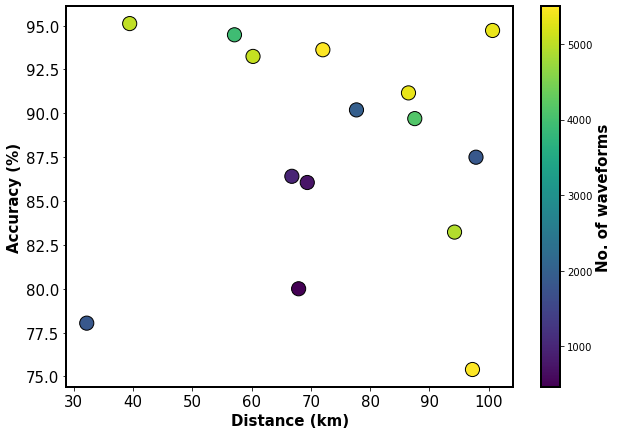

In [108]:
plt.rcParams['axes.linewidth'] = 2
fig, ax = plt.subplots(figsize=[10,7])
mappable = ax.scatter(dist, np.array(acc)*100, c= size, edgecolor='black', s=200)
ax.set_xlabel('Distance (km)', fontsize=15, weight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=15, weight='bold')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=10)
cbar = plt.colorbar(mappable = mappable)

cbar.set_label('No. of waveforms', fontsize=15, fontweight='bold')

In [113]:
## Testing the optimum number of trees
X,y  = load_dataset('SCM')
acc1 = []
no_of_trees = []
for i in tqdm(range(50,550,50)):
    no_of_trees.append(i)
    acc1.append(forest_test(X,y, n_estimators=i)[0])

217.10571384429932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [18:31<00:00, 111.13s/it]


Text(0.5, 1.0, 'AK.SCM.BHE')

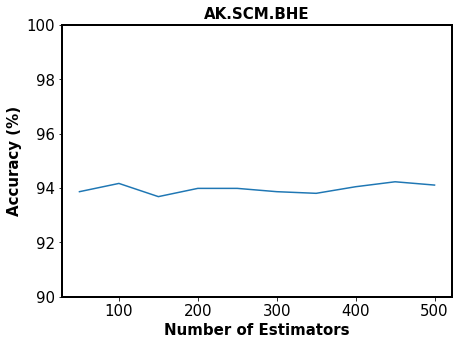

In [129]:
fig, ax = plt.subplots(figsize=[7,5])
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=10)
plt.plot(no_of_trees, np.array(acc1)*100)
plt.ylim(90,100)
plt.xlabel('Number of Estimators', fontsize=15, weight='bold')
plt.ylabel('Accuracy (%)', fontsize=15, weight='bold')
plt.title('AK.SCM.BHE', fontsize=15, weight='bold')

In [131]:
X,y = load_dataset('SCM',l=0)
print(forest_test(X,y, n_estimators=50)[0])

X,y = load_dataset('SCM',l=1)
print(forest_test(X,y, n_estimators=50)[0])

X,y = load_dataset('SCM',l=2)
print(forest_test(X,y, n_estimators=50)[0])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2936/2936 [02:18<00:00, 21.26it/s]


226.16633796691895
0.939890710383


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2936/2936 [02:19<00:00, 21.00it/s]


226.44288539886475
0.939890710383


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2936/2936 [02:17<00:00, 21.33it/s]


225.3119912147522
0.947783849423


## Experimenting on the Filtered Dataset.

Will it give better accuracy? 
Apparently it seems like 1-10 Hz is where the difference happens. 


In [139]:
def load_dataset(station, l=2):
    start_time = time.time()
    X1 = []
    for i in tqdm(range(len(glob('Data/icequake_waveforms/*'+station+'*')))):
        st = obspy.read(glob('Data/icequake_waveforms/*'+station+'*')[i])
        st.filter(type='bandpass', freqmin=3, freqmax=10)
        if len(np.abs(np.fft.fft(st[l].data))) == 15000:
            X1.append(np.abs(np.fft.fft(st[l].data))/np.max(np.abs(np.fft.fft(st[l].data))))    
            
    X2 = []
    for i in tqdm(range(len(glob('Data/earthquake_waveforms/*'+station+'*')))):
        st = obspy.read(glob('Data/earthquake_waveforms/*'+station+'*')[i])
        st.filter(type='bandpass', freqmin=3, freqmax=10)
        if len(np.abs(np.fft.fft(st[l].data))) == 15000:
            X2.append(np.abs(np.fft.fft(st[l].data))/np.max(np.abs(np.fft.fft(st[l].data))))   
            
            
    X = X1 +X2
    X = np.array(X)
    a = np.ones(len(X1))
    b = np.zeros(len(X2))
    c = np.concatenate([a,b])
    y = c        
    
    end_time = time.time()
    print(end_time-start_time)

    return X,y

In [136]:
## Filter 1-20 Hz
X,y = load_dataset('SCM',l=2)
print(forest_test(X,y, n_estimators=50))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2936/2936 [02:35<00:00, 18.90it/s]


254.3805878162384
(0.93806921675774135, 38.664702567999484)


In [138]:
## Filter 1-10 Hz
X,y = load_dataset('SCM',l=2)
print(forest_test(X,y, n_estimators=50))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2936/2936 [02:32<00:00, 19.21it/s]


253.01148056983948
(0.94049787492410442, 32.52462707400082)


In [140]:
## Filter 3-10 Hz
X,y = load_dataset('SCM',l=2)
print(forest_test(X,y, n_estimators=50))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2936/2936 [02:32<00:00, 19.25it/s]


251.25030970573425
(0.95081967213114749, 29.602329126999393)


## Let's Apply PCA


In [150]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
pca.explained_variance_ratio_

array([ 0.42769545,  0.09429398,  0.01405982])

In [151]:
print(forest_test(X_pca,y, n_estimators=50))

(0.8986035215543412, 0.20094036500086077)


In [154]:
acc_pca = []
no_of_components = []
for i in tqdm(range(1,1000)):
    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(X)
    #pca.explained_variance_ratio_
    no_of_components.append(i)
    acc_pca.append(forest_test(X_pca,y, n_estimators=50)[0])

 53%|████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 527/999 [1:30:55<1:21:26, 10.35s/it]


KeyboardInterrupt: 

In [72]:
size = []
for i in tqdm(range(len(stations))):
    size.append(len(glob('Data/icequake_waveforms/*'+stations[i]+'*'))+len(glob('Data/earthquake_waveforms/*'+stations[i]+'*')))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 13.04it/s]


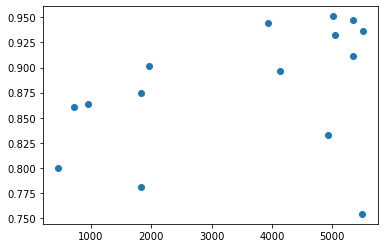

In [75]:
plt.scatter(size,acc)

In [25]:
stream = obspy.read(glob('Data/icequake_waveforms/*KLU*')[0])
stream

3 Trace(s) in Stream:
AK.KLU..BHE | 2020-12-09T15:11:32.628400Z - 2020-12-09T15:16:32.608400Z | 50.0 Hz, 15000 samples
AK.KLU..BHN | 2020-12-09T15:11:32.628400Z - 2020-12-09T15:16:32.608400Z | 50.0 Hz, 15000 samples
AK.KLU..BHZ | 2020-12-09T15:11:32.628400Z - 2020-12-09T15:16:32.608400Z | 50.0 Hz, 15000 samples

117.42174077033997


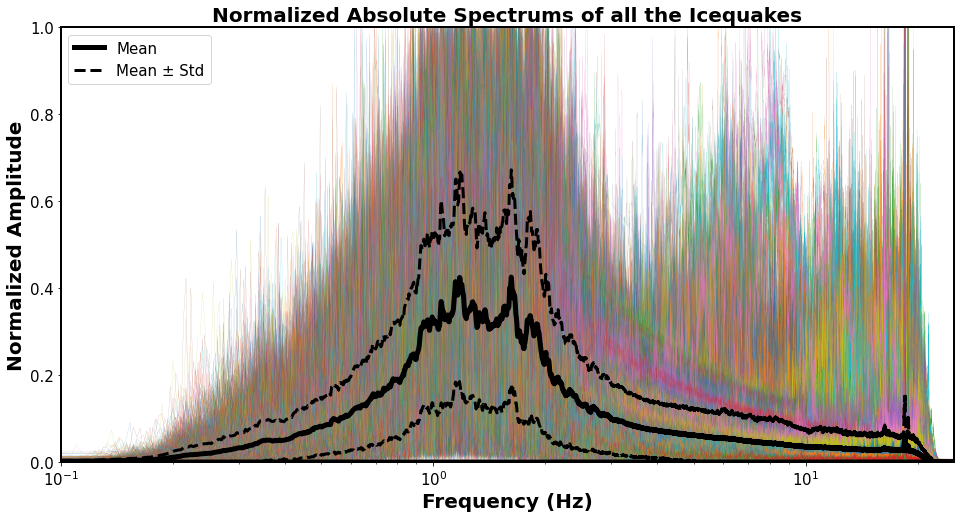

In [268]:
l = 0
plt.rcParams['axes.linewidth'] = 2
start_time = time.time()
X1 = []
plt.figure(figsize=[16,8])
for i in range(len(glob('Data/icequake_waveforms/*SCM*'))):
    st = obspy.read(glob('Data/icequake_waveforms/*SCM*')[i])
    st.filter(type='bandpass', freqmin=1, freqmax=20)
    freq = np.fft.fftfreq(len(st[l].data), d=st[l].stats.delta) ## We are taking the Z component by st[2].
    
    
    plt.plot(freq, np.abs(np.fft.fft(st[l].data))/np.max(np.abs(np.fft.fft(st[l].data))), lw=0.1)
    if len(np.abs(np.fft.fft(st[l].data))) == 15000:
        X1.append(np.abs(np.fft.fft(st[l].data))/np.max(np.abs(np.fft.fft(st[l].data))))
#print(np.shape(X1))    
plt.plot(freq, np.mean(X1, axis=0), lw=5, c='k', label='Mean')
plt.plot(freq, np.mean(X1, axis=0)+np.std(X1, axis=0), lw=3, c='k', ls='--',label='Mean ± Std')
plt.plot(freq, np.mean(X1, axis=0)-np.std(X1, axis=0), lw=3, c='k', ls='--')
plt.tick_params(axis='both', which='major', labelsize=15)
#plt.set_xticklabels(labels=stations, rotation=15, size=15
plt.legend(fontsize=15)
plt.xlim(0.1,25)
plt.xlabel('Frequency (Hz)', fontsize=20, fontweight='bold')
plt.ylabel('Normalized Amplitude', fontsize=20, fontweight='bold')
plt.ylim(0,1)
plt.xscale('log')
plt.title('Normalized Absolute Spectrums of all the Icequakes', fontsize=20, fontweight='bold')
end_time = time.time()
print(end_time-start_time)


In [162]:
np.mean(X1, axis=0)

array([ 0.98831251,  0.05820153,  0.0311137 , ...,  0.01792703,
        0.0311137 ,  0.05820153])

In [182]:
iq = st

In [270]:
eq

3 Trace(s) in Stream:
AK.SCM..BHE | 2018-10-16T19:20:15.468400Z - 2018-10-16T19:25:15.448400Z | 50.0 Hz, 15000 samples
AK.SCM..BHN | 2018-10-16T19:20:15.468400Z - 2018-10-16T19:25:15.448400Z | 50.0 Hz, 15000 samples
AK.SCM..BHZ | 2018-10-16T19:20:15.468400Z - 2018-10-16T19:25:15.448400Z | 50.0 Hz, 15000 samples

In [271]:
iq

3 Trace(s) in Stream:
AK.SCM..BHE | 2012-06-28T04:27:36.568400Z - 2012-06-28T04:32:36.548400Z | 50.0 Hz, 15000 samples
AK.SCM..BHN | 2012-06-28T04:27:36.568400Z - 2012-06-28T04:32:36.548400Z | 50.0 Hz, 15000 samples
AK.SCM..BHZ | 2012-06-28T04:27:36.568400Z - 2012-06-28T04:32:36.548400Z | 50.0 Hz, 15000 samples

175.8826584815979


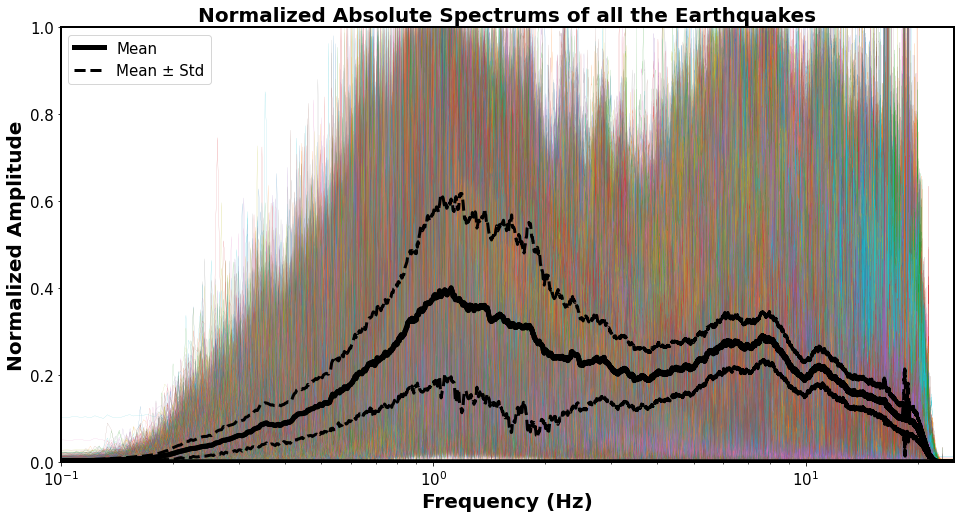

In [269]:
l = 0

start_time = time.time()
X2 = []
plt.figure(figsize=[16,8])
for i in range(len(glob('Data/earthquake_waveforms/*SCM*'))):
    st = obspy.read(glob('Data/earthquake_waveforms/*SCM*')[i])
    st.filter(type='bandpass', freqmin=1, freqmax=20)
    freq = np.fft.fftfreq(len(st[l].data), d=st[l].stats.delta) ## We are taking the Z component by st[2].
    
    
    plt.plot(freq, np.abs(np.fft.fft(st[l].data))/np.max(np.abs(np.fft.fft(st[l].data))), lw=0.1)
    if len(np.abs(np.fft.fft(st[l].data))) == 15000:
        X2.append(np.abs(np.fft.fft(st[l].data))/np.max(np.abs(np.fft.fft(st[l].data))))
#print(np.shape(X2))    
plt.plot(freq, np.mean(X2, axis=0), lw=5, c='k')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.plot(freq, np.mean(X2, axis=0), lw=5, c='k', label='Mean')
plt.plot(freq, np.mean(X2, axis=0)+np.std(X1, axis=0), lw=3, c='k', ls='--',label='Mean ± Std')
plt.plot(freq, np.mean(X2, axis=0)-np.std(X1, axis=0), lw=3, c='k', ls='--')
plt.xlim(0.1,25)
plt.ylim(0,1)
plt.xscale('log')
plt.legend(fontsize=15)
plt.xlabel('Frequency (Hz)', fontsize=20, fontweight='bold')
plt.ylabel('Normalized Amplitude', fontsize=20, fontweight='bold')
plt.title('Normalized Absolute Spectrums of all the Earthquakes', fontsize=20, fontweight='bold')
end_time = time.time()
print(end_time-start_time)


In [184]:
eq = st

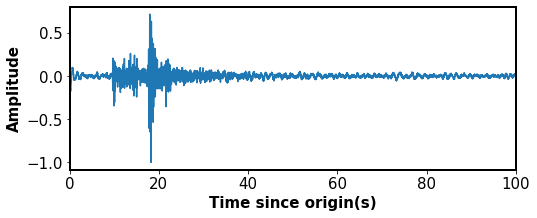

In [261]:
plt.figure(figsize=[8,3])
plt.plot(eq[0].times(), eq[0].data/np.max(np.abs(eq[0].data)))
plt.xlim(0,100)
plt.xlabel('Time since origin(s)', fontsize=15, fontweight='bold')
plt.ylabel('Amplitude', fontsize=15, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=15)
#plt.yticks([])

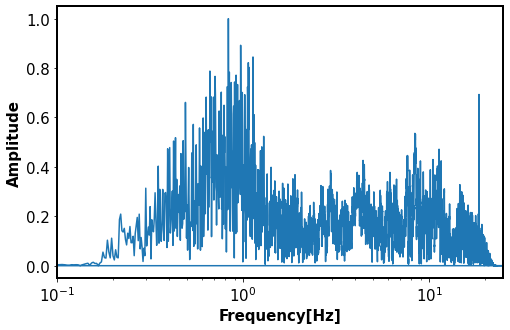

In [260]:
plt.figure(figsize=[8,5])
plt.plot(freq, np.abs(np.fft.fft(eq[0].data))/np.max(np.abs(np.fft.fft(eq[0].data))))
plt.xscale('log')
plt.xlim(0.1,25)
plt.xlabel('Frequency[Hz]', fontsize=15, fontweight='bold')
plt.ylabel('Amplitude', fontsize=15, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=15)
#plt.yticks([])

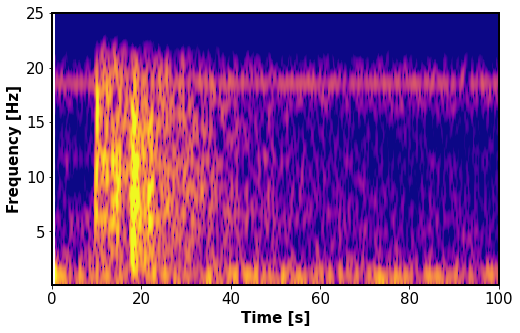

In [258]:
plt.rcParams['figure.figsize'] = 8,5
fig = eq[0].spectrogram(show=False,wlen=1,dbscale=True,cmap='plasma')
ax = fig.axes[0]
ax.set_ylim(0.1,25)
plt.xlim(0, 100)
#ax.set_xlim(0,100)
ax.set_xlabel('Time [s]', fontsize=15, fontweight='bold')
ax.set_ylabel('Frequency [Hz]', fontsize=15, fontweight='bold')
ax.set_title('')
#plt.colorbar(fig)
plt.tick_params(axis='both', which='major', labelsize=15)
im = ax.images[0]
im.set_clim(vmin=-10,vmax=30)

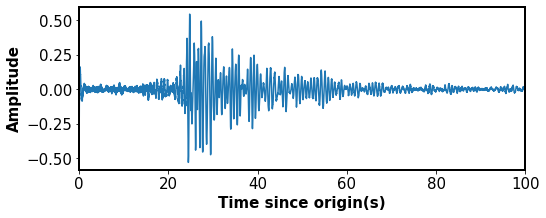

In [263]:
plt.figure(figsize=[8,3])
plt.plot(iq[0].times(), iq[0].data/np.max(np.abs(eq[0].data)))
plt.xlim(0,100)
plt.xlabel('Time since origin(s)', fontsize=15, fontweight='bold')
plt.ylabel('Amplitude', fontsize=15, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=15)
#plt.yticks([])

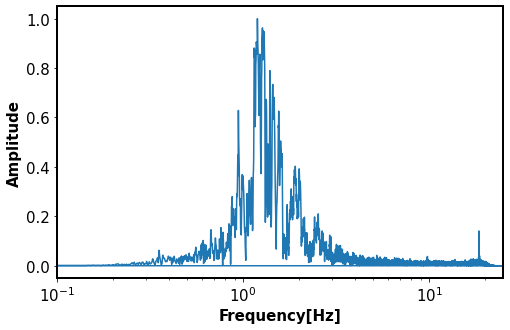

In [264]:
plt.figure(figsize=[8,5])
plt.plot(freq, np.abs(np.fft.fft(iq[0].data))/np.max(np.abs(np.fft.fft(iq[0].data))))
plt.xscale('log')
plt.xlim(0.1,25)
plt.xlabel('Frequency[Hz]', fontsize=15, fontweight='bold')
plt.ylabel('Amplitude', fontsize=15, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=15)
#plt.yticks([])

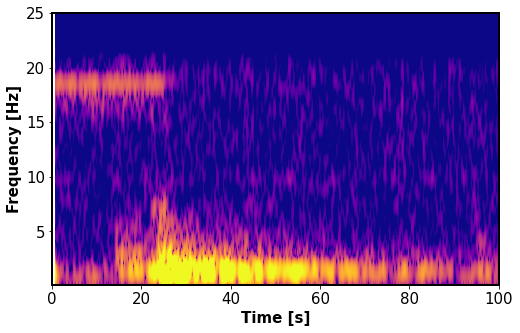

In [267]:
plt.rcParams['figure.figsize'] = 8,5
fig = iq[0].spectrogram(show=False,wlen=1,dbscale=True,cmap='plasma')
ax = fig.axes[0]
ax.set_ylim(0.1,25)
plt.xlim(0, 100)
#ax.set_xlim(0,100)
ax.set_xlabel('Time [s]', fontsize=15, fontweight='bold')
ax.set_ylabel('Frequency [Hz]', fontsize=15, fontweight='bold')
ax.set_title('')
#plt.colorbar(fig)
plt.tick_params(axis='both', which='major', labelsize=15)
im = ax.images[0]
im.set_clim(vmin=-10,vmax=30)

In [275]:
glob('Data/earthquake_waveforms/*SCM*')[-1]

'Data/earthquake_waveforms/earthquake_2580_SCM.mseed'

In [276]:
eq

3 Trace(s) in Stream:
AK.SCM..BHE | 2018-10-16T19:20:15.468400Z - 2018-10-16T19:25:15.448400Z | 50.0 Hz, 15000 samples
AK.SCM..BHN | 2018-10-16T19:20:15.468400Z - 2018-10-16T19:25:15.448400Z | 50.0 Hz, 15000 samples
AK.SCM..BHZ | 2018-10-16T19:20:15.468400Z - 2018-10-16T19:25:15.448400Z | 50.0 Hz, 15000 samples

In [ ]:
iq_lat, iq_lon = 61.2017, -146.9143
eq_lat, eq_lon = 61.5537, -146.4212
stn_lat, stn_lon = 61.832001, -147.328995

In [ ]:
region = [-149.0, -144, 60, 62]
fig = pygmt.Figure()
pygmt.makecpt(cmap='relief',series='-5000/5000/1000',continuous=True)
topo_data = '@earth_relief_15s'
pygmt.config(FORMAT_GEO_MAP="ddd.x")
fig.grdimage(grid=topo_data,region=region,projection='M5i',shading=True,cmap=True,
            frame=["WSne", "xaf", "yaf"])
#pygmt.makecpt(cmap="plasma", series=[np.min(depths),25])
fig.coast(area_thresh = 10000,
    shorelines='1p,black',
#          water="lightblue",
          region=region,
#          borders="1/thick",
         frame=["WSne", "xaf", "yaf"], 
          map_scale='"g-147.3/60.5+w20"')

#fig.colorbar(frame='af+l"Elevation(m)"')
pygmt.makecpt(cmap="plasma", series = [70,100])

fig.plot(x=eq_lon,y=eq_lat,style='c0.2c',color='green',pen='0.5p,black',
         region=region,transparency=0, label='Earthquakes')
fig.plot(x=stn_lon, y=stn_lat,style='i0.5c',color='red',pen='1p,black',
         region=region, cmap=False)
#fig.plot(x=gl_lons,y=gl_lats,style='a0.6c',color='yellow',pen='0.5p,black',
#         region=region)
#fig.text(text=glaciers, y=gl_lats, x=np.array(gl_lons)+0.2,font="7p,Helvetica-Bold,black",fill='white')
fig.text(text=stations[3:],y=stn_lats[3:]+0.00,x=stn_lons[3:]+0.30,font="7p,Helvetica-Bold,black",fill='white')
fig.legend()
region1 = [-148.2,-148,61.1,61.2]
rectangle = [[region1[0], region1[2], region1[1], region1[3]]]
fig.plot(data=rectangle, style="r+s", pen="1p,black",projection='M5i')

(0.0, 300.0)

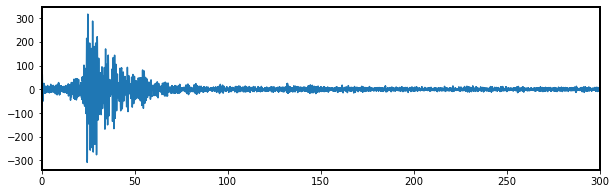

In [194]:
fig, ax = plt.subplots(ncols = 2, nrows=3)

(0.0, 4000.0)

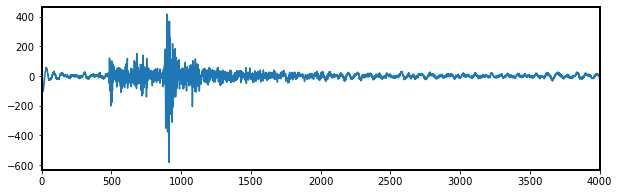

In [190]:
plt.figure(figsize=[10,3])
plt.plot(eq[0].data)
plt.xlim(0,4000)

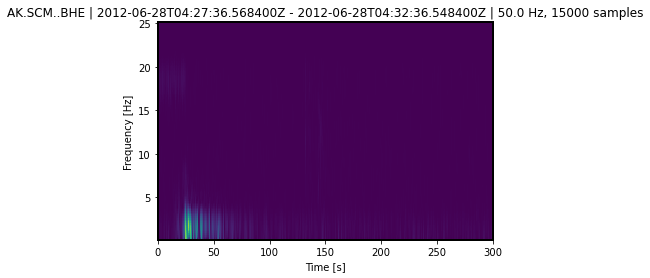

In [192]:
iq[0].spectrogram()

In [28]:
X = X1 +X2
X = np.array(X)
a = np.ones(len(X1))
b = np.zeros(len(X2))
c = np.concatenate([a,b])
y = c


In [34]:
def forest_test(X, Y, n_estimators= 300):
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, 
                                                        test_size = 0.30, 
                                                        random_state = 101)
    #X_train_fs, X_test_fs, fs = select_features(X_Train, Y_Train, X_Test)
    
    start = time.process_time()
    trainedforest = RandomForestClassifier(n_estimators=n_estimators).fit(X_Train,Y_Train)
    dur = time.process_time() - start
    predictionforest = trainedforest.predict(X_Test)
    #print(confusion_matrix(Y_Test,predictionforest))
    #print(classification_report(Y_Test,predictionforest))
    acc = accuracy_score(Y_Test, predictionforest)
    
    return acc, dur

In [38]:
no_of_trees = []
acc = []
dur = []
for i in tqdm(range(50,550,50)):
    no_of_trees.append(i)
    acc.append(forest_test(X,c, n_estimators=i)[0])
    dur.append(forest_test(X,c, n_estimators=i)[1])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [25:31<00:00, 153.17s/it]


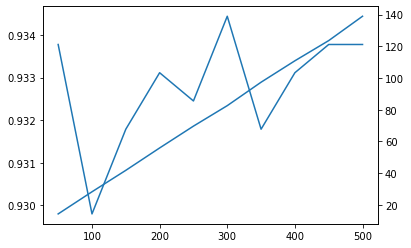

In [42]:
fig, ax = plt.subplots()
ax.plot(no_of_trees, acc)
ax1 = ax.twinx()
ax1.plot(no_of_trees, dur)

In [16]:
forest_test(X,c, n_estimators=100)

37.00038160299994
[[847  39]
 [ 34 580]]
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       886
         1.0       0.94      0.94      0.94       614

    accuracy                           0.95      1500
   macro avg       0.95      0.95      0.95      1500
weighted avg       0.95      0.95      0.95      1500



In [32]:
forest_test(X,c, n_estimators=50)

13.892240982999965
[[826  48]
 [ 48 588]]
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       874
         1.0       0.92      0.92      0.92       636

    accuracy                           0.94      1510
   macro avg       0.93      0.93      0.93      1510
weighted avg       0.94      0.94      0.94      1510

0.93642384106
